In [1]:
import numpy as np
import networkx as nx
from ipysigma import Sigma
import matplotlib.pyplot as plt

np.random.seed(0)

In [2]:
class Mutation:
    count = 0

    @staticmethod
    def new(n):
        start = Mutation.count
        Mutation.count += n
        stop = Mutation.count
        return range(start, stop)

In [3]:
class Node:
    node_count = 0
    def __init__(self, t):
        self.id = Node.node_count
        Node.node_count += 1
        
        self.t = t
        self.parent = None
        self.children = []
        self.mutated = False
        self.mutations = range(0)

    def adopt(self, child):
        self.children.append(child)
        child.parent = self

    def to_networkx(self):
        G = nx.DiGraph()
        mut_str = self.mutations if len(self.mutations) > 0 else ''
        G.add_node(self.id, label=f"{self.id} ({self.t:.2f}) {mut_str}")
        for child in self.children:
            G.add_edge(self.id, child.id)
            G = nx.compose(G, child.to_networkx())
        return G
    
    def mutate(self, rate):
        assert self.mutated is False
        assert self.parent is not None
        n = np.random.poisson(rate * (self.t - self.parent.t))
        self.mutations = Mutation.new(n)
        for child in self.children:
            child.mutate(rate)
        return n
    
    def get_mutation_set(self):
        # return set of my mutations union mutations of my parent
        if self.parent is None:
            return set(self.mutations)
        return set(self.mutations).union(self.parent.get_mutation_set())
        

In [4]:
def coalesce(pop_size, sample_size, initial_t, final_t):
    t = final_t

    leaves = [Node(t) for _ in range(sample_size)]
    orphans = leaves.copy()

    while len(orphans) > 1:
        tmean = 2 * pop_size / (sample_size * (sample_size - 1))
        t -= np.random.exponential(tmean)

        if t < initial_t:
            break

        # Pick two orphans to coalesce, remove then from the list of orphas
        node1 = np.random.choice(orphans)
        orphans.remove(node1)

        node2 = np.random.choice(orphans)
        orphans.remove(node2)

        # Create a new node that is the parent of the two orphans
        parent = Node(t)
        parent.adopt(node1)
        parent.adopt(node2)

        # Add the parent to the list of orphans
        orphans.append(parent)

    return orphans, leaves

In [5]:
class Individual:
    def __init__(self, t, origin, n_pop, n_sample, mut_rate):
        self.t = t
        self.origin = origin
        self.n_pop = n_pop
        self.n_sample = n_sample
        self.mut_rate = mut_rate

        self.sample = [Node(t) for _ in range(n_sample)]
        for node in self.sample:
            origin.adopt(node)

    def evolve(self, dt):
        # Coalesce the sample and get the orphans
        orphans, leaves = coalesce(self.n_pop, self.n_sample, self.t, self.t + dt)

        # Pick the parents of the orphans
        parents = np.random.choice(self.sample, len(orphans), replace=False)

        # Adopt the orphans
        for parent, orphan in zip(parents, orphans):
            parent.adopt(orphan)

        for orphan in orphans:
            orphan.mutate(self.mut_rate)

        self.sample = leaves
        self.t += dt

    def contaminate(self):
        # return a new individual originating from a random node in the sample
        origin = np.random.choice(self.sample)
        return Individual(self.t, origin, self.n_pop, self.n_sample, self.mut_rate)

    def get_mutation_sets(self):
        return [node.get_mutation_set() for node in self.sample]
    
    def get_non_fixated_mutation_distribution(self):
        mutation_sets = self.get_mutation_sets()
        all_mutations = set.union(*mutation_sets)
        distribution = {m: 0 for m in all_mutations}
        for mutation_set in mutation_sets:
            for m in mutation_set:
                distribution[m] += 1
        
        # ignore fixated mutations
        distribution = {k: v for k, v in distribution.items() if v < self.n_sample}
        
        # sort by value
        return {k: v for k, v in sorted(distribution.items(), key=lambda item: item[1], reverse=True)}



In [6]:
n_pop = 1000
n_sample = 10
mut_rate = 0.1
T = 100

t = 0
origin = Node(t)
a = Individual(t, origin, n_pop, n_sample, mut_rate)
a.evolve(T)
b = a.contaminate()
a.evolve(T)
b.evolve(T)
c = b.contaminate()
a.evolve(T)
b.evolve(T)
c.evolve(T)


G = origin.to_networkx()
# set colors for the nodes in the sample
for node in a.sample:
    G.nodes[node.id]["color"] = "red"
for node in b.sample:
    G.nodes[node.id]["color"] = "blue"
for node in c.sample:
    G.nodes[node.id]["color"] = "green"
Sigma(G, hide_info_panel=True)

Sigma(nx.DiGraph with 116 nodes and 115 edges)

In [7]:
def simulate(n_pop, n_sample, mut_rate, T):
    t = 0
    origin = Node(t)
    a = Individual(t, origin, n_pop, n_sample, mut_rate)
    a.evolve(T)
    b = a.contaminate()
    a.evolve(T)
    b.evolve(T)
    dist_a = a.get_non_fixated_mutation_distribution().values()
    dist_b = b.get_non_fixated_mutation_distribution().values()
    return dist_a, dist_b

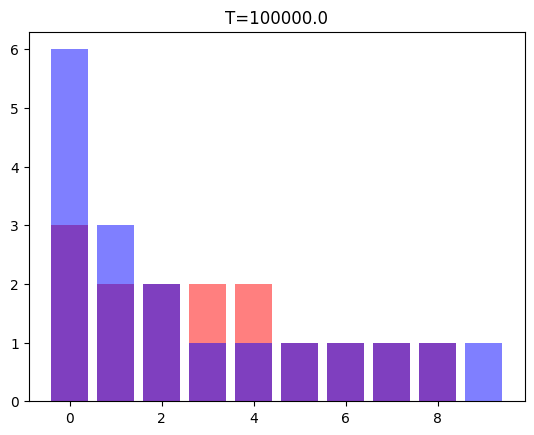

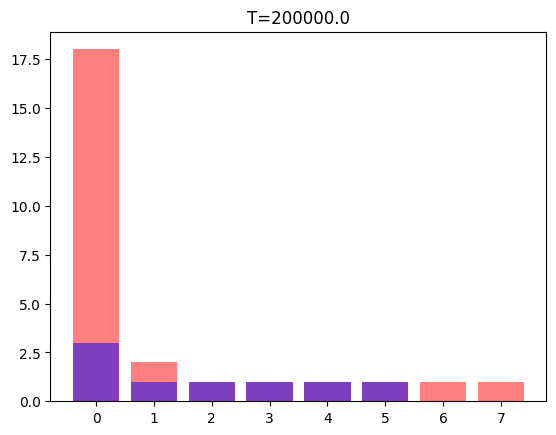

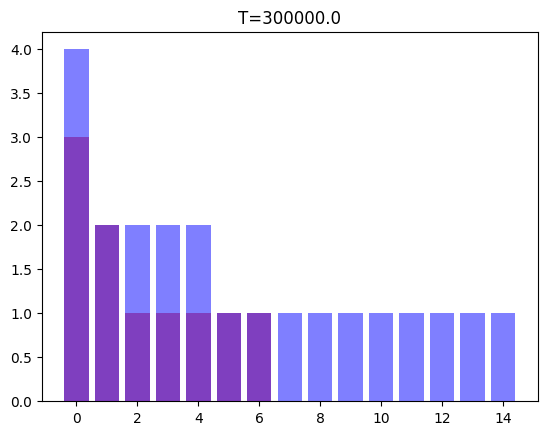

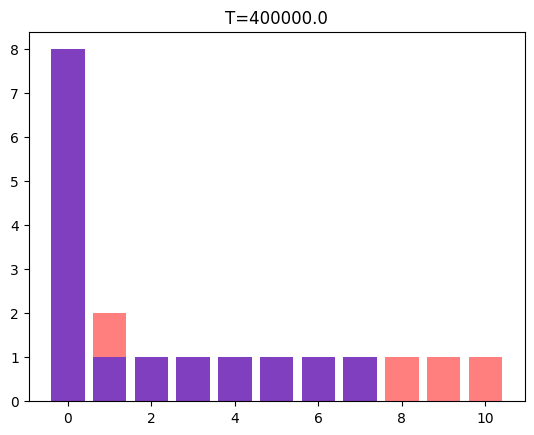

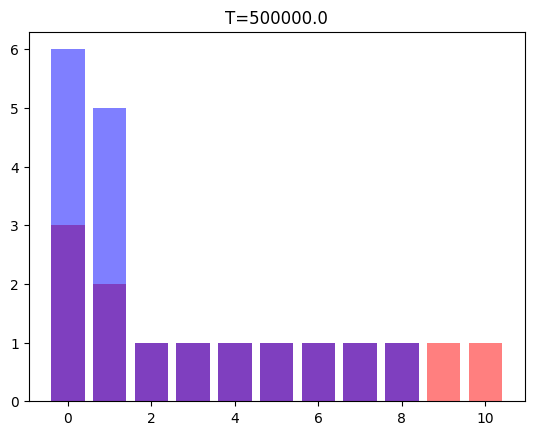

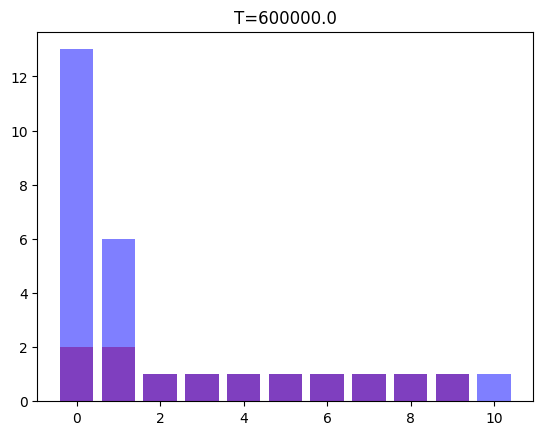

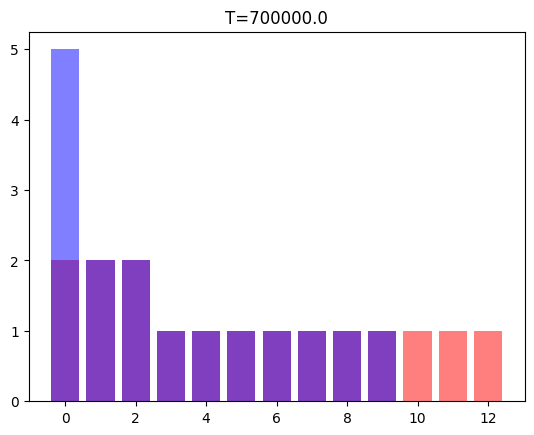

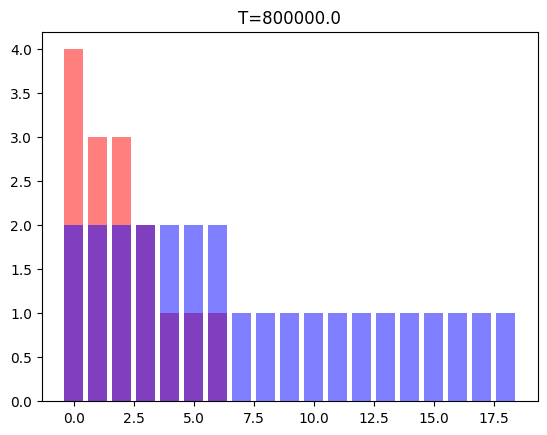

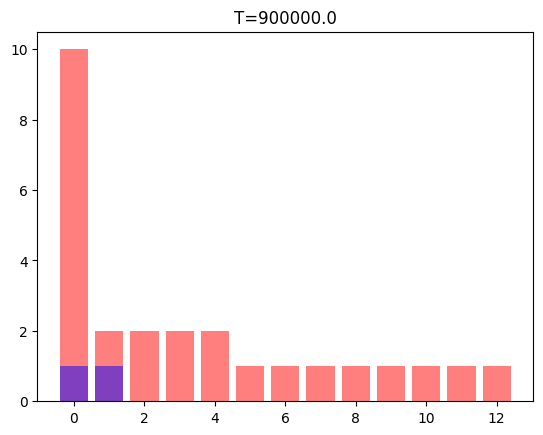

In [8]:
Ts = np.arange(1e5, 1e6, 1e5)

n_pop = 1e4
n_sample = 100
mut_rate = 1e-3

for T in Ts:
    dist_a, dist_b = simulate(n_pop, n_sample, mut_rate, T)
    plt.bar(range(len(dist_a)), dist_a, color='red', alpha=0.5)
    plt.bar(range(len(dist_b)), dist_b, color='blue', alpha=0.5)
    plt.title(f"T={T}")
    plt.show()


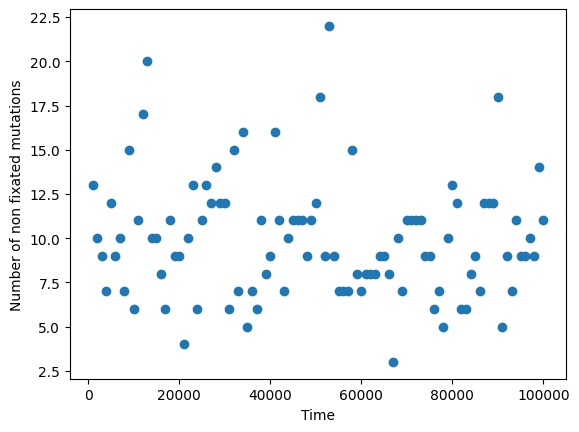

In [9]:
# Plot the number of mutations non fixated in the population in function of time
n_sample = 100
n_pop = n_sample ** 2
mut_rate = 1e-3
T = 1000

t = 0
origin = Node(t)
a = Individual(t, origin, n_pop, n_sample, mut_rate)
n_mutations = []
times = []
for _ in range(100):
    a.evolve(T)
    dist = a.get_non_fixated_mutation_distribution().values()
    n_mutations.append(len(dist))
    times.append(a.t)

plt.scatter(times, n_mutations)
plt.xlabel("Time")
plt.ylabel("Number of non fixated mutations")
plt.show()